In [11]:
% cd /content
! rm -rf yolo-detector
! git clone https://bitbucket.org/EverWinter23/yolo-detector

/content
Cloning into 'yolo-detector'...
remote: Counting objects: 116, done.
remote: Compressing objects: 100% (113/113), done.
remote: Total 116 (delta 34), reused 0 (delta 0)
Receiving objects: 100% (116/116), 55.65 KiB | 130.00 KiB/s, done.
Resolving deltas: 100% (34/34), done.


In [0]:
! git pull

remote: Counting objects: 4, done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 4 (delta 3), reused 0 (delta 0)
Unpacking objects: 100% (4/4), done.
From https://bitbucket.org/EverWinter23/xbox
   7de40ae..d4a020a  voc        -> origin/voc
Updating 7de40ae..d4a020a
Fast-forward
 utils/utils.py | 7 ++-----
 1 file changed, 2 insertions(+), 5 deletions(-)


In [4]:
% cd /content
% mkdir data
% cd data
! chmod +x /content/yolo-detector/data/get_coco_dataset.sh
! /content/yolo-detector/data/get_coco_dataset.sh
! ls
% cd .. 

/content
/content/data
Cloning into 'coco'...
remote: Enumerating objects: 953, done.
remote: Total 953 (delta 0), reused 0 (delta 0), pack-reused 953
Receiving objects: 100% (953/953), 11.70 MiB | 1.79 MiB/s, done.
Resolving deltas: 100% (566/566), done.
--2019-05-07 06:56:44--  https://pjreddie.com/media/files/train2014.zip
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13510435630 (13G) [application/zip]
Saving to: ‘train2014.zip’

train2014.zip       100%[===================>]  12.58G  18.2MB/s    in 14m 0s  

2019-05-07 07:10:45 (15.3 MB/s) - ‘train2014.zip’ saved [13510435630/13510435630]

--2019-05-07 07:10:45--  https://pjreddie.com/media/files/val2014.zip
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6645

In [35]:
! ls /content/data/coco

5k.part      images			  license.txt  README.txt
5k.txt	     instances_train-val2014.zip  LuaAPI       results
annotations  labels			  MatlabAPI    trainvalno5k.part
common	     labels.tgz			  PythonAPI    trainvalno5k.txt


In [5]:
% cd /content
! chmod +x yolo-detector/weights/download_weights.sh
! mkdir weights
% cd weights
! /content/yolo-detector/weights/download_weights.sh
! ls
% cd ..

/content
/content/weights
--2019-05-07 07:24:03--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  15.4MB/s    in 15s     

2019-05-07 07:24:19 (15.6 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]

--2019-05-07 07:24:19--  https://pjreddie.com/media/files/yolov3-tiny.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35434956 (34M) [application/octet-stream]
Saving to: ‘yolov3-tiny.weights’

yolov3-tiny.weights 100%[===================>]  33.79M  11.7MB/s    in 2.9s    

2019-05-07 07:24:23 (11.7 MB/s) - ‘yolov3-tiny.weights’ saved 

In [0]:
from google.colab import files
files.download('/content/data/coco/labels/train2014/COCO_train2014_000000000009.txt') 


In [16]:
% cd /content/yolo-detector
from utils import *
from datasets import *
from darknet import *
from parse_config import *

model_def = '/content/yolo-detector/config/yolov3.cfg'
data_cfg = parse_data_config('/content/yolo-detector/config/coco.data')
weights_path = '/content/weights/yolov3.weights'
valid_path = data_cfg['valid']
class_names = load_classes(data_cfg['names'])

img_size=416
batch_size=32
iou_thres=0.5
conf_thres=0.001
nms_thres=0.5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Darknet(model_def).to(device)
model.load_darknet_weights(weights_path)

/content/PyTorch-YOLOv3
Already on 'master'
Your branch is up to date with 'origin/master'.


In [0]:
def evaluate(model, path, iou_thres, conf_thres, nms_thres, img_size, batch_size):
    model.eval()

    # Get dataloader
    dataset = ListDataset(path, img_size=img_size, augment=False, multiscale=False)
    dataloader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=False, num_workers=1, collate_fn=dataset.collate_fn
    )

    Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

    labels = []
    sample_metrics = []  # List of tuples (TP, confs, pred)
    for batch_i, (_, imgs, targets) in enumerate(tqdm.tqdm(dataloader, desc="Detecting objects")):

        # Extract labels
        labels += targets[:, 1].tolist()
        # Rescale target
        targets[:, 2:] = xywh2xyxy(targets[:, 2:])
        targets[:, 2:] *= img_size

        imgs = Variable(imgs.type(Tensor), requires_grad=False)

        with torch.no_grad():
            outputs = model(imgs)
            outputs = non_max_suppression(outputs, conf_thres=conf_thres, nms_thres=nms_thres)

        sample_metrics += get_batch_stats(outputs, targets, iou_thres=iou_thres)

    # Concatenate sample statistics
    true_positives, pred_scores, pred_labels = [np.concatenate(x, 0) for x in list(zip(*sample_metrics))]
    precision, recall, AP, f1, ap_class = ap_per_class(true_positives, pred_scores, pred_labels, labels)

    return precision, recall, AP, f1, ap_class


In [0]:
iou_val = [.20, .30, .40, .50, .60, .70, .80, .90]
pr_iou = [[(0, 0) for j in range(len(iou_val))] for i in range(80)]

for j, x in enumerate(iou_val):
    precision, recall, AP, f1, ap_class = evaluate(model, valid_path, x, conf_thres, nms_thres, img_size, batch_size)
    print(f"mAP: {AP.mean()}")
    with open('/content/yolo-detecor/iou_val_' + str(x), 'w') as f:
        f.write('mAP={}\n'.format(AP.mean()))
        f.write(', '.join(str(y) for y in precision)+'\n')
        f.write(', '.join(str(y) for y in recall)+'\n')

In [3]:
# run setup code for this notebook.
import matplotlib.pyplot as plt

%matplotlib inline

# set default size of plots
#plt.rcParams['figure.figsize'] = (10.0, 8.0)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [0]:
iou_val = [.20, .30, .40, .50, .60, .70, .80, .90]
p_c = [[[] for j in range(len(iou_val))] for i in range(80)]
r_c = [[[] for j in range(len(iou_val))] for i in range(80)]
mAP = [float(0) for i in range(len(iou_val))]
for j, x in enumerate(iou_val):        
    with open('/content/yolo-detector/pr-data/iou_val_' + str(x), 'r') as f:
        stuff = f.readlines()
        _, mAPx = stuff[0].split('=')
        
        mAP[j] = float(mAPx)
        p = stuff[-2].split(',')
        p = [float(y.strip()) for y in p]
        r = stuff[-1].split(',')
        r = [float(y.strip()) for y in r]
        
        for i in range(80):
            p_c[i][j] = p[i]
            r_c[i][j] = r[i]

In [10]:
! ls /content/yolo-detector/pr-data

iou_val_0.40  iou_val_0.60  iou_val_0.75  iou_val_0.90
iou_val_0.50  iou_val_0.65  iou_val_0.80  iou_val_0.95
iou_val_0.55  iou_val_0.70  iou_val_0.85


Text(0, 0.5, 'mAP Score')

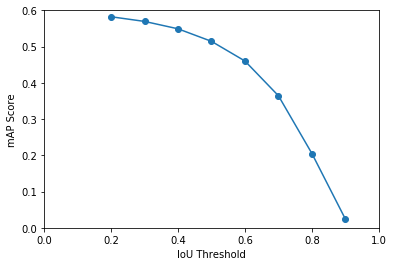

In [14]:
plt.scatter(iou_val, mAP)
plt.plot(iou_val, mAP)
plt.xlim(0, 1)
plt.ylim(0, 0.60)
plt.xlabel('IoU Threshold')
plt.ylabel('mAP Score')

In [10]:
% cd /content/yolo-detector
! git checkout master
precision, recall, AP, f1, ap_class = evaluate(model, valid_path, x, conf_thres=0.5, nms_thres, img_size, batch_size)

print("Average Precisions:")
for i, c in enumerate(ap_class):
    print(f"+ Class '{c}' ({class_names[c]}) - AP: {AP[i]}")
print(f"mAP: {AP.mean()}")

/content/xbox
Namespace(batch_size=32, class_path='data/coco.names', conf_thres=0.001, data_config='/content/fconfig', img_size=416, iou_thres=0.9, model_def='config/yolov3.cfg', n_cpu=8, nms_thres=0.5, weights_path='/content/weights/yolov3.weights')
Compute mAP...
Detecting objects: 100% 625/625 [05:36<00:00,  1.92it/s]
Computing AP: 100% 80/80 [00:01<00:00, 67.19it/s]
Average Precisions:
+ Class '0' (person) - AP: 0.02275419029911321
+ Class '1' (bicycle) - AP: 0.012198917996658573
+ Class '2' (car) - AP: 0.009620697886002404
+ Class '3' (motorbike) - AP: 0.021195937666934617
+ Class '4' (aeroplane) - AP: 0.06067062505136116
+ Class '5' (bus) - AP: 0.11500160645953511
+ Class '6' (train) - AP: 0.05023936809672541
+ Class '7' (truck) - AP: 0.04054632509816449
+ Class '8' (boat) - AP: 0.0030420440495726206
+ Class '9' (traffic light) - AP: 0.005720345110159394
+ Class '10' (fire hydrant) - AP: 0.05952043467989605
+ Class '11' (stop sign) - AP: 0.15626127359037756
+ Class '12' (parking 